In [1]:
import datetime
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Union, Tuple

from dateutil.relativedelta import relativedelta

from itertools import product

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm.notebook import tqdm

Применим для прогнозирования данных регрессионные модели из библиотеки statsmodels.

In [2]:
df = pd.read_csv('data_for_train/consumption_and_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


Приведем ряд к стационарному, отняв от от значений значения соответсвтующие прошлой неделе:

In [3]:
temp_df = pd.concat(
                        [
                            pd.DataFrame(columns=df.columns,
                                         index = pd.date_range(start=df.index[0] - relativedelta(weeks=1),
                                                               end=df.index[0],
                                                               freq='H')[:-1]),
                            df.copy()
                        ],
                        axis=0
                    )
print('temp_df.shape', temp_df.shape)
temp_df.head(2)

temp_df.shape (65160, 2)


,one_hour_consumption,one_hour_temperature
2015-12-25 00:00:00,NaN,NaN
2015-12-25 01:00:00,NaN,NaN


In [4]:
week_ago_index = tuple(index - relativedelta(weeks=1) for index in df.index)

df['week_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(week_ago_index), 'one_hour_consumption'].values
df['week_ago_consumption_diff'] = df['one_hour_consumption'] - df['week_ago_consumption']

df.dropna(axis=0, inplace=True)
df.drop('week_ago_consumption', axis=1, inplace=True)

print('df.shape', df.shape)
df.head(2)

df.shape (64824, 3)


,one_hour_consumption,one_hour_temperature,week_ago_consumption_diff
datetime,,,
2016-01-08 00:00:00,3702.966667,-12.433333,-260.016667
2016-01-08 01:00:00,3521.783333,-12.400000,-286.483333


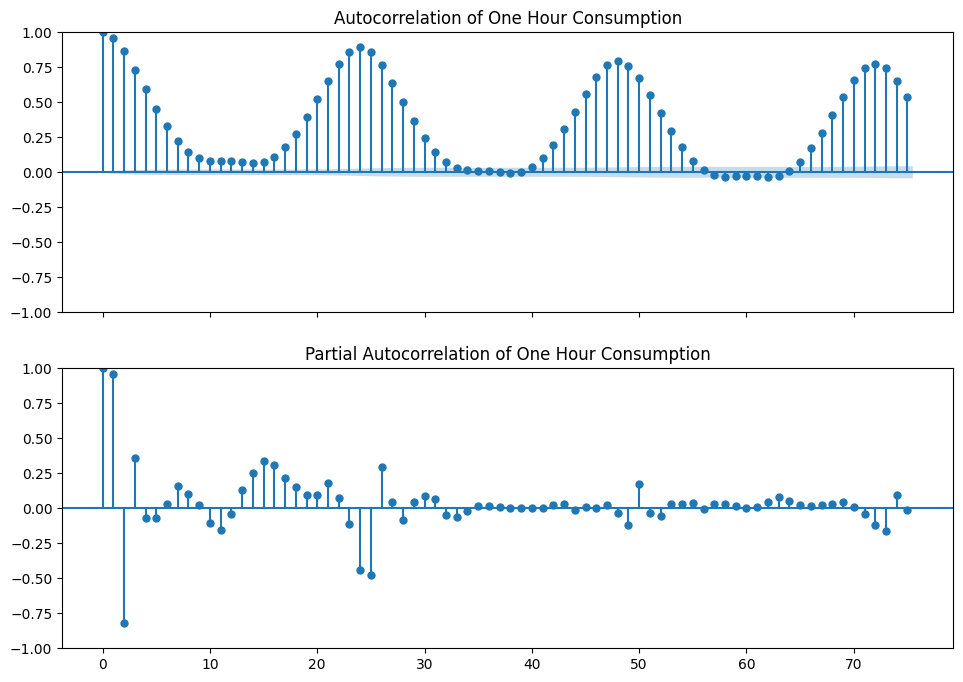

_______________________________________________________________________________________________________________________________


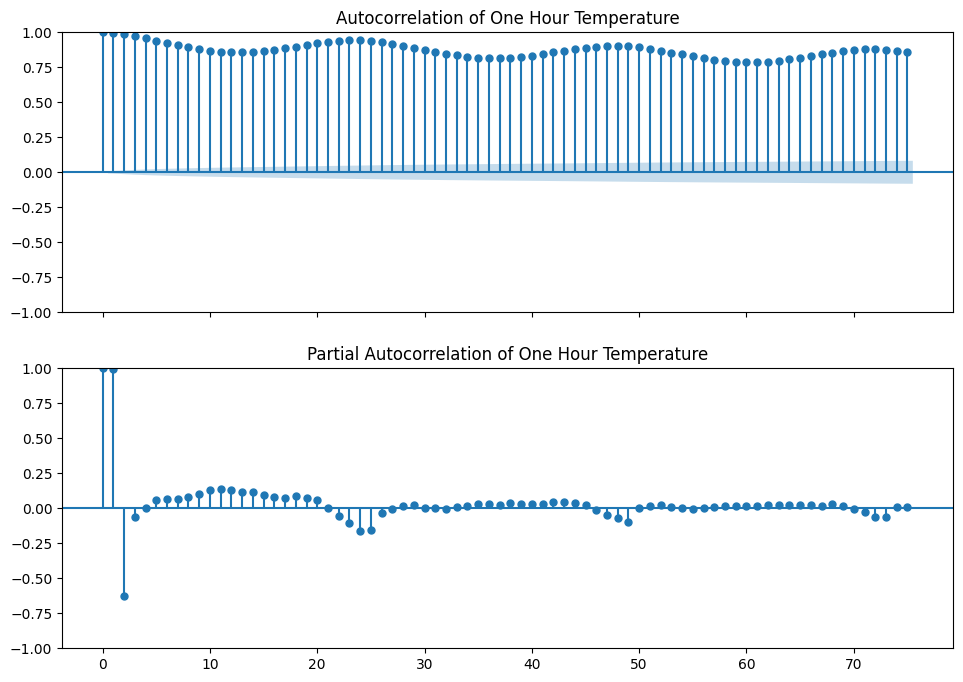

_______________________________________________________________________________________________________________________________


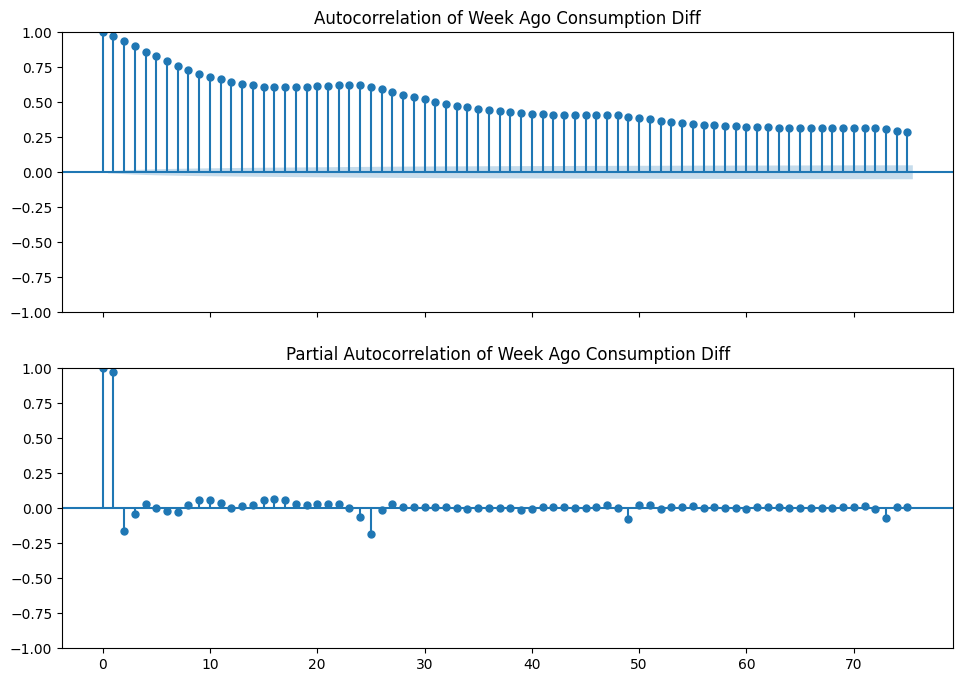

_______________________________________________________________________________________________________________________________


In [5]:
for feature, values in df.items():
    fig, (ax_acf, ax_pacf) = plt.subplots(nrows=2, figsize=(11.5, 8), sharex=True)
    plot_acf(x=values, ax=ax_acf, lags=75, title=f"Autocorrelation of {feature.replace('_', ' ').title()}")
    plot_pacf(x=values, ax=ax_pacf, lags=75, method='ywm', title=f"Partial Autocorrelation of {feature.replace('_', ' ').title()}")
    plt.show()
    print("_" * 127)

Попробуем подобать параметры для модели ARIMA с помощью auto_arima.

In [6]:
# stepwise_fit = auto_arima(df['week_ago_consumption_diff'],
#                           seasonal=False,
#                           start_p=0, start_q=0,
#                           max_p=20, max_q=20,
#                           d=0,
#                           trace=True,
#                           suppress_warnings=True,
#                           error_action='ignore',
#                           stepwise=True)

# были получены параметры p, d, q = (4, 0, 0)
# тестовый mae получился 130.546
# попробуем грид сёрч

Подготовим для предсказания моделью данные:

In [14]:
test_index = df[(df.index >= '2022-11-30 11:00:00') & (df.index.hour == 11)].index[:-1]

In [15]:
pd.DataFrame(df.loc[test_index[0]]).T

,one_hour_consumption,one_hour_temperature,week_ago_consumption_diff
2022-11-30 11:00:00,5624.931579,-3.2,36.146512


In [16]:
pd.DataFrame(df.loc[test_index[-1]]).T

,one_hour_consumption,one_hour_temperature,week_ago_consumption_diff
2023-05-30 11:00:00,4737.57552,22.22,-65.346136


Применим грид сёрч для подбора параметров:

In [17]:
def arima_fit(df        : Union[pd.DataFrame, pd.Series],
              df_true   : pd.DataFrame,
              p         : int,
              d         : int,
              q         : int
              ) -> Tuple[float, Union[pd.DataFrame, None]]:
    """
    Функция для обучения модели ARIMA
    Принимает на вход датафрейм с данными
    Датафрейм с реальными данными
    Пробные параметры модели
    """
    global test_index
    try: 
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  

            df_pred = pd.DataFrame(index=df_true.index, data={'y_pred': np.nan})

            for index in tqdm(test_index):
                train_df = df.loc[:index, 'week_ago_consumption_diff']
                model = ARIMA(train_df, order=(p, d, q))
                model_fit = model.fit()

                start_index = index + relativedelta(hours=1)
                end_index = start_index + relativedelta(hours=35)
                forecast = model_fit.predict(start=start_index, end=end_index)

                df_pred['y_pred'].loc[start_index + relativedelta(hours=12):end_index] = forecast[-24:].values

            mae = mean_absolute_error(df_true['week_ago_consumption_diff'], df_pred['y_pred']).round(3)
            
    except ValueError:
        return (float('inf'), None)

    return (mae, df_pred)

In [18]:
df_true = pd.DataFrame(df[df.index >= '2022-12-01']['week_ago_consumption_diff'])
print('df_true.shape', df_true.shape)
df_true.head(2)

df_true.shape (4368, 1)


,week_ago_consumption_diff
datetime,
2022-12-01 00:00:00,18.108212
2022-12-01 01:00:00,-1.461270


In [ ]:
p = range(15)
d = range(1)
q = range(2)

best_params = None
best_mae = float('inf')
best_pred = None


for comb in tqdm(list(product(p, d, q))):
    params = {'p' : comb[0],
              'd' : comb[1],
              'q' : comb[2]}
    cur_mae, cur_pred = arima_fit(df=df, df_true=df_true, **params)
    print(f'params: {params}, cur_mae: {cur_mae}')
    if cur_mae < best_mae:
        best_mae = cur_mae
        best_params = params
        best_pred = cur_pred
print(f'best_params: {best_params}, best_mae: {best_mae}')

# best_params: {'p': 14, 'd': 0, 'q': 0}, best_mae: 127.654

Наилучшими параметрами получились "потолочные". Однако революционного улучшения параметров не происходит. Поэтому остановимся на полученном результате.

In [20]:
df_pred = best_pred

In [21]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

In [22]:
print('MSE :', mean_squared_error(df_true['week_ago_consumption_diff'], df_pred['y_pred']).round(3))
print('MAE :', mean_absolute_error(df_true['week_ago_consumption_diff'], df_pred['y_pred']).round(3))

MSE : 43955.552
MAE : 127.654


Для отображения результатов восстановим по прошлонедельным значениям реальные знаения потребления.

In [23]:
week_ago_index = tuple(index - relativedelta(weeks=1) for index in df.index)
df['week_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(week_ago_index), 'one_hour_consumption'].values
df.dropna(axis=0, inplace=True)

In [24]:
df_true['true_consumption'] = df_true['week_ago_consumption_diff'] + df.loc[df_true.index, 'week_ago_consumption']
df_pred['pred_consumption'] = df_pred['y_pred'] + df.loc[df_true.index, 'week_ago_consumption']

In [25]:
df_grouped_true = pd.DataFrame(df_true['true_consumption']).groupby([df_true.index.date, df_true.index.hour]).sum()
df_unstacked_true = df_grouped_true.unstack()
df_unstacked_true.index = pd.to_datetime(df_unstacked_true.index)

df_grouped_pred = pd.DataFrame(df_pred['pred_consumption']).groupby([df_pred.index.date, df_pred.index.hour]).sum()
df_unstacked_pred = df_grouped_pred.unstack()
df_unstacked_pred.index = pd.to_datetime(df_unstacked_pred.index)

--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


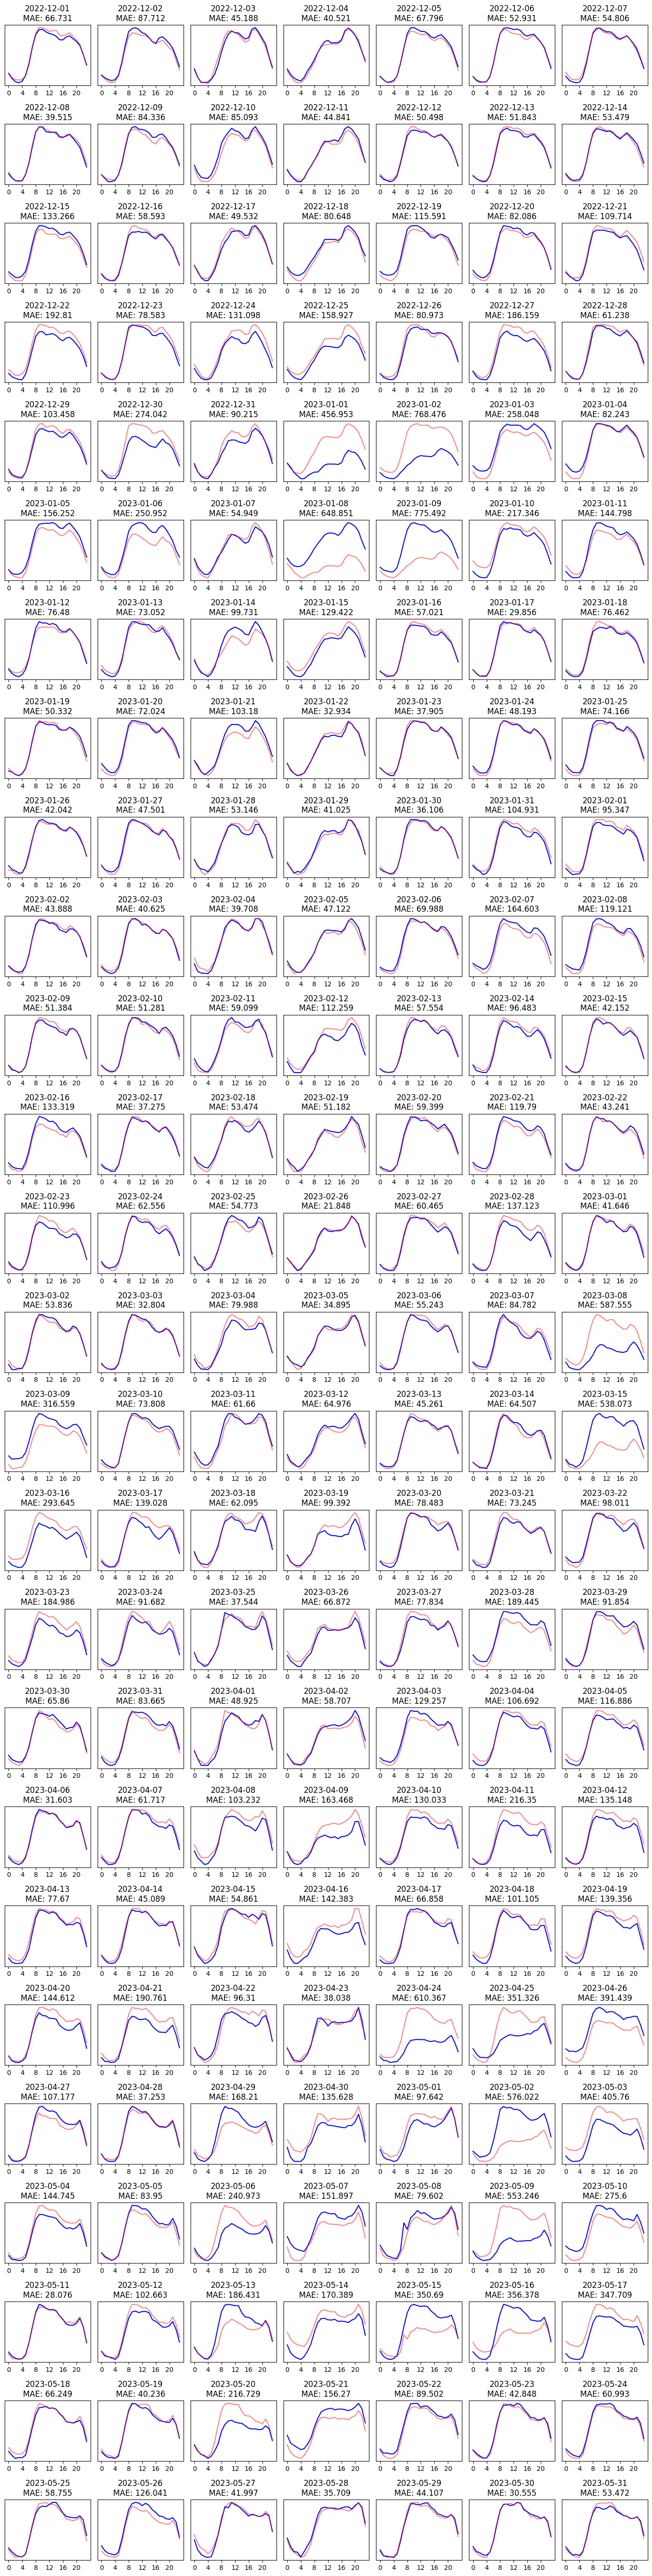

In [26]:
plot_predicts(df_true=df_unstacked_true,
              df_pred=df_unstacked_pred,
              days_shift=0)

Итоговый MAE на тестовых данных составил 127.654